In [48]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
from bold_dementia.data.study import balance_control
from bold_dementia.connectivity import Atlas, fast_hist, reshape_pvalues, vec_idx_to_mat_idx
from bold_dementia.connectivity import plot_ordered_matrix as plot_matrix # TODO This could be better

import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection


from formulaic import model_matrix
from scipy.stats import ttest_ind

ATLAS = "schaeffer"
SOFT = False
pd.options.mode.copy_on_write = True

In [49]:
matrices_path = Path(
    f"{config['output_dir']}/connectivity/atlas-{ATLAS}_balanced-sex-age_z-transformed_strategy-high_pass-motion-wm_csf"
)
print(f"Fetching data in {matrices_path}")
# TODO Allow longitudinal and add subject_id to random effects
# TODO Intracranial volume
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")
atlas = Atlas.from_name(ATLAS, SOFT)

Fetching data in /homes_unix/jlegrand/data/Memento/output/connectivity/atlas-schaeffer_balanced-sex-age_z-transformed_strategy-high_pass-motion-wm_csf


FileNotFoundError: [Errno 2] No such file or directory: '/homes_unix/jlegrand/data/Memento/output/connectivity/atlas-schaeffer_balanced-sex-age_z-transformed_strategy-high_pass-motion-wm_csf/AD.joblib'

In [ ]:
def mat_to_vec(mat):
    n = len(mat)
    tril_i = np.tril_indices(n, k=-1)
    flat_mat = mat[tril_i].ravel()
    return flat_mat

def z_transform_mat(mat):
    flat_mat = mat_to_vec(mat)
    z_transformed = np.arctanh(flat_mat)
    return reshape_pvalues(z_transformed)


In [ ]:
AD_matrices_z = np.array(tuple(map(z_transform_mat, AD_matrices)))
control_matrices_z = np.array(tuple(map(z_transform_mat, control_matrices)))

In [ ]:
def z_transform_to_vec(mat):
    vec = mat_to_vec(mat)
    return np.arctanh(vec)

AD_vec = np.array([z_transform_to_vec(mat) for mat in AD_matrices])
control_vec = np.array([z_transform_to_vec(mat) for mat in control_matrices])

flatcov = ttest_ind(
    control_vec,
    AD_vec,
    alternative="two-sided"
)

In [ ]:
# TODO Check order consistency in scripts before
AD_df = pd.read_csv(matrices_path / "balanced_AD.csv", index_col=0)
control_df = pd.read_csv(matrices_path / "balanced_control.csv", index_col=0)
df = pd.concat((AD_df, control_df))

In [ ]:
fc = np.vstack((AD_vec, control_vec))
l = fc.shape[1]
labels = atlas.labels
rows, cols = vec_idx_to_mat_idx(l)
edges = [f"{labels[i]}_{labels[j]}" for i, j in zip(rows, cols)]

fc = pd.DataFrame(fc, columns=edges)

df["AD"] = np.where(df.scan_to_onset < 0, 1, 0)
df = pd.concat([df.reset_index(drop=True), fc], axis=1, join="inner")
cleaned_df = df.dropna(subset="APOE_eps4")

## Visualisation of covariates 

### Age

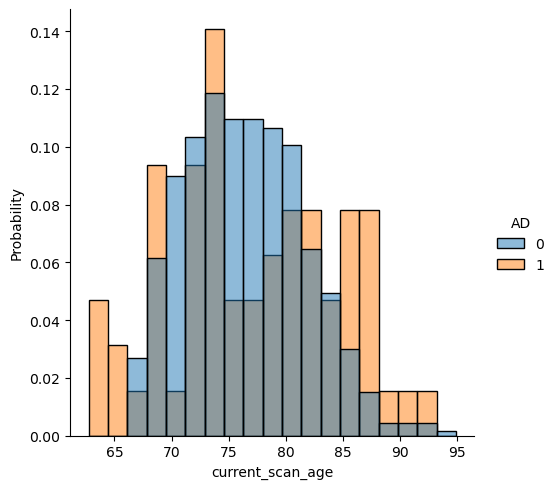

In [ ]:
sns.displot(
    df,
    x="current_scan_age",
    hue="AD",
    stat="probability",
    common_norm=False,
)
plt.show()

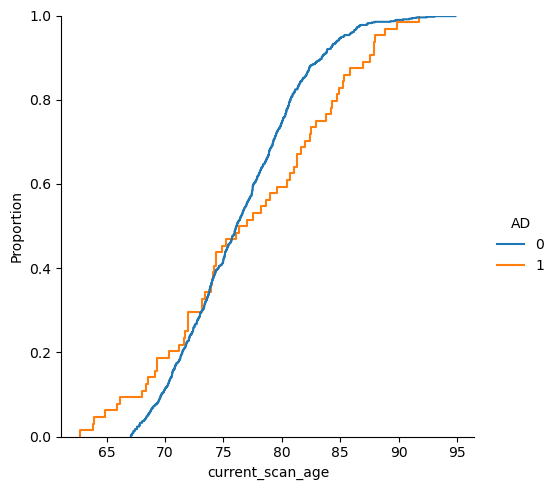

In [ ]:
sns.displot(
    df,
    x="current_scan_age",
    hue="AD",
    kind="ecdf",
)
plt.show()

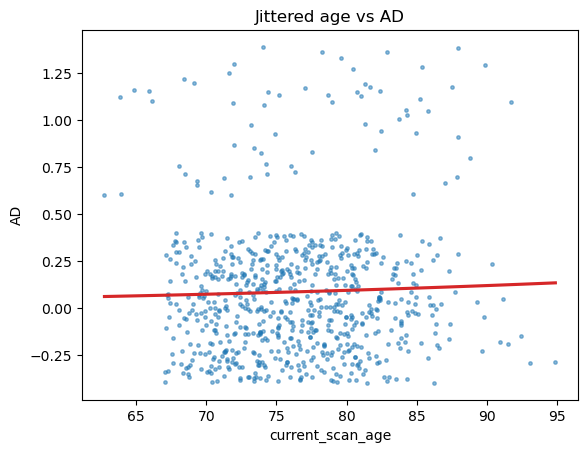

In [ ]:
sns.regplot(
    df,
    x="current_scan_age", 
    y="AD",
    logistic=True,
    ci=None,
    line_kws={"color":"tab:red"}, 
    scatter_kws={"alpha": 0.5, "s":6},
    y_jitter=0.4,
)
plt.title("Jittered age vs AD")
plt.show()

### APOE allele

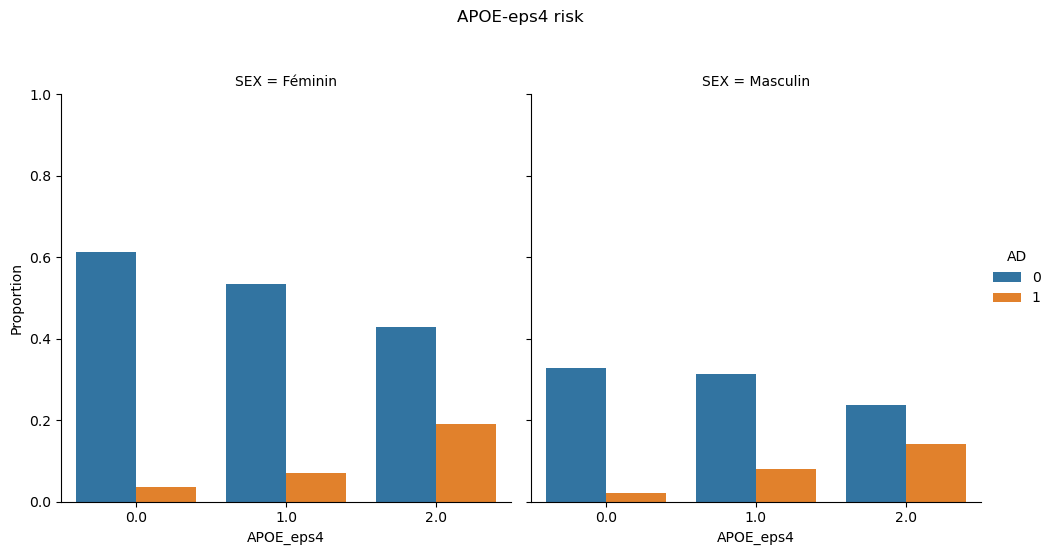

In [ ]:
x, y = 'APOE_eps4', "AD"
f = (cleaned_df.groupby(x)[[y, "SEX"]]
.value_counts(normalize=True)
.rename('Proportion')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='Proportion',hue=y,kind='bar', col="SEX"))
plt.ylim(0, 1)
plt.suptitle("APOE-eps4 risk", y=1.1)
plt.show()

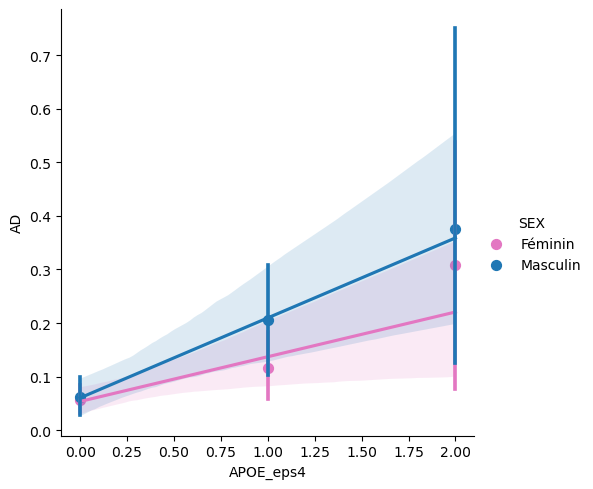

In [ ]:
sns.lmplot(
    y="AD",
    x="APOE_eps4",
    data=cleaned_df,
    x_estimator=np.mean,
    #logistic=True,
    hue="SEX",
    palette=["tab:pink", "tab:blue"]
)
plt.show()

## Model fitting

In [50]:
tst_edge_name = 'R Ant IPS_Cing'
lhs, rhs = model_matrix(f"`{tst_edge_name}` ~ AD", df.dropna(subset="NIVETUD"))

In [51]:
model = sm.OLS(endog=lhs, exog=rhs)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         R Ant IPS_Cing   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.741
Date:                Wed, 28 Feb 2024   Prob (F-statistic):              0.187
Time:                        16:52:48   Log-Likelihood:                 120.95
No. Observations:                 730   AIC:                            -237.9
Df Residuals:                     728   BIC:                            -228.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3458      0.008     43.467      0.000       0.330       0.361
AD             0.0355      0.027      1.320      0.187      -0.017       0.088
==============================================================================
Omnibus:                        1.424   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                1.320
Skew:                          -0.013   Prob(JB):                        0.517
Kurtosis:                       3.207   Cond. No.                         3.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
# TODO Return more fitting info
# TODO CEN_ANOM as random effect?
def fit_edges(ROI_name, dataframe):
    lhs, rhs = model_matrix(f"`{ROI_name}` ~ AD + scale(current_scan_age) + SEX + NIVETUD + APOE_eps4", dataframe)
    model = sm.OLS(endog=lhs, exog=rhs)
    result = model.fit()
    return result.params.AD, result.pvalues.AD
    

In [72]:
test_results = []
# TODO Parallelize
for edge in edges:
    test_results.append(fit_edges(edge, df.dropna(subset=["NIVETUD", "APOE_eps4"])))

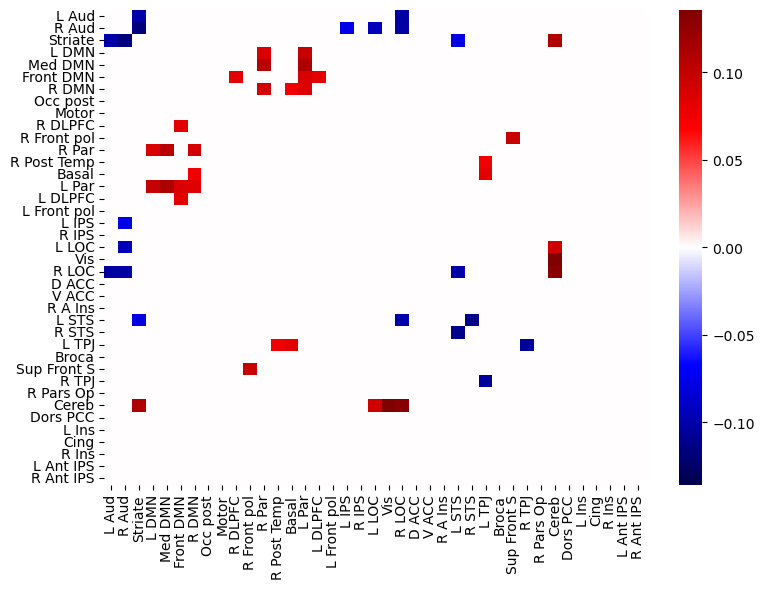

In [75]:
stats = [tr[0] for tr in test_results]
pvalues = [tr[1] for tr in test_results]
_, pvalues_corr = fdrcorrection(pvalues)

statmat = reshape_pvalues(stats)

pmat = reshape_pvalues(pvalues_corr)
display_mat = np.where(pmat < config["alpha"], statmat, 0)

plot_matrix(display_mat, atlas=atlas)
plt.show()

In [76]:
from nilearn import plotting
coords = atlas.get_coords()

view = plotting.view_connectome(display_mat, coords)
view.open_in_browser()

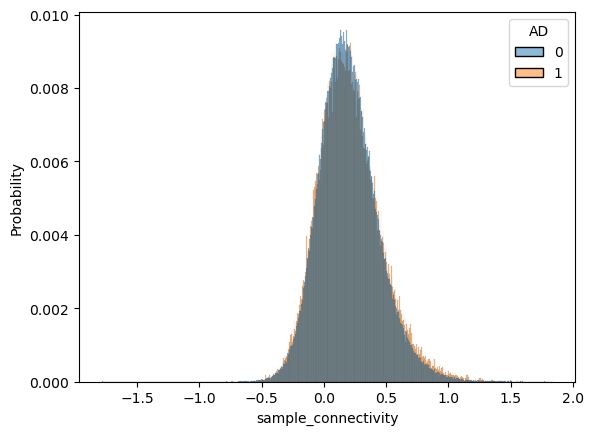

In [ ]:
conn_AD = df[edges + ["AD"]]
m = conn_AD.melt(id_vars='AD', var_name="edge", value_name="sample_connectivity")
sns.histplot(m, x="sample_connectivity", hue="AD", stat="probability", common_norm=False)
plt.show()

### Assumptions on residuals

In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(result)

#### Normality

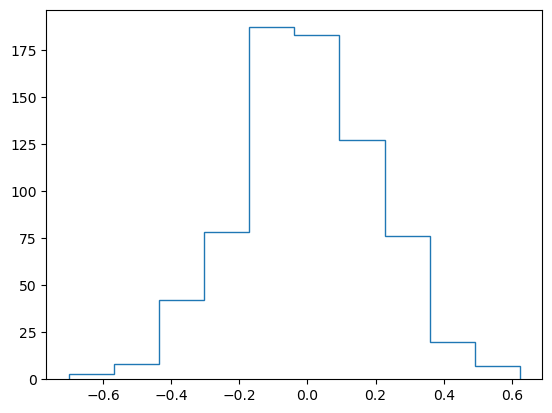

In [ ]:
plt.hist(result.resid, histtype="step")
plt.show()

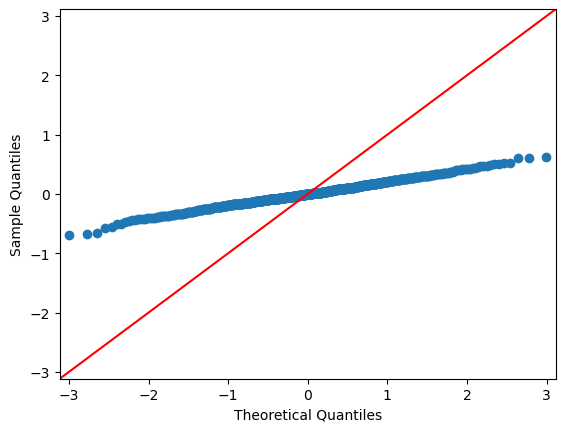

In [ ]:
from statsmodels.graphics.gofplots import qqplot

qqplot(influence.resid, line="45")
plt.show()

#### Homoskedasticity

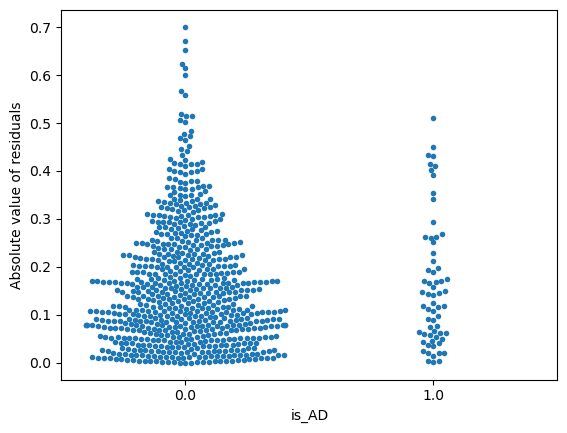

In [ ]:
# Spread Location plot
sns.swarmplot(
    x=model.exog[:, 1],
    y=abs(result.resid),
    size=4
)
plt.xlabel("is_AD")
plt.ylabel("Absolute value of residuals")
plt.show()

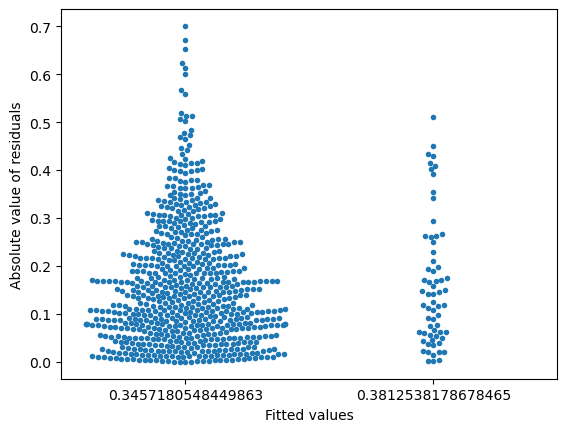

In [ ]:
sns.swarmplot(
    x=result.fittedvalues,
    y=abs(result.resid),
    size=4
)
plt.xlabel("Fitted values")
plt.ylabel("Absolute value of residuals")
plt.show()

#### Linearity

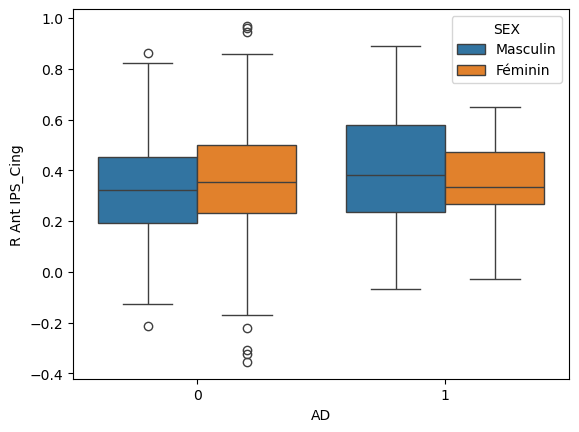

In [ ]:
# Linearity holds for categorical features
sns.boxplot(
    df,
    x="AD",
    y=tst_edge_name,
    hue="SEX"
)
plt.show()